## Load and visualize FashionMNIST 

The first step in any classification problem is to look at the dataset you are working with. This will give you some details about the format of images and labels, as well as some insight into how you might approach defining a network to recognize patterns in such an image set.

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt 
import numpy as np
import torch
import torchvision

# data loading and transforming 
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader 
from torchvision import transforms 

## Load training data 

In [3]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

data_transform = transforms.ToTensor()
train_data = FashionMNIST(root='./datasets', train=True, download=False, transform=data_transform)

print("Train data, number of images: ", len(train_data))

Processing...
Done!
Train data, number of images:  60000


## Data iteration and batching

In [4]:
batch_size = 20
# DataLoader is an iterator
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Specify the image classes
classes =['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Visualize some training data

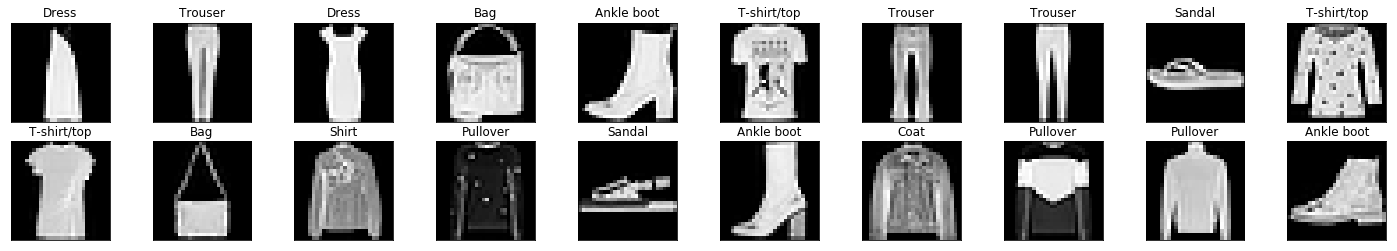

In [6]:
# Obtain one batch
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap ='gray')
    ax.set_title(classes[labels[idx]])

## View an image in more detail

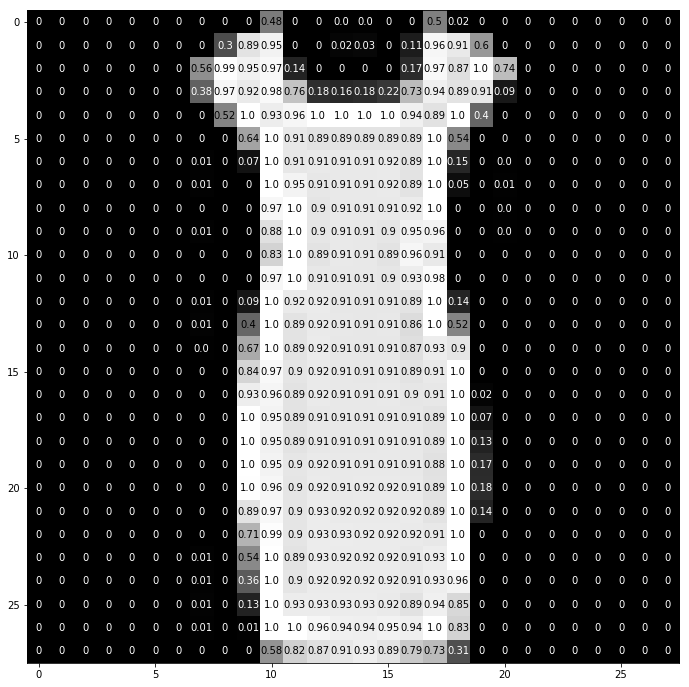

In [7]:
# select an image by index
idx = 2
img = np.squeeze(images[idx])

# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')